In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
sys.path.insert(0, os.path.abspath('../palin/python'))

In [ ]:
#from palin.simulation import Experiment
from palin.simulation.experiment import Experiment
from palin.simulation.analyser import Analyser
from palin.simulation.experiments.simple_experiment import SimpleExperiment
from palin.simulation.experiments.double_pass_experiment import DoublePassExperiment
from palin.simulation.trial import Int2Trial, Int1Trial 
from palin.simulation.observers.linear_observer import LinearObserver
from palin.simulation.analysers.kernel_distance import KernelDistance
from palin.simulation.analysers.internal_noise_value import InternalNoiseValue
from palin.kernels.classification_images import ClassificationImage 
from palin.kernels.glm_kernel import GLMKernel
from palin.internal_noise.double_pass import DoublePass

from palin.internal_noise.intercept_method import InterceptMethod
from palin.simulation.simulation import Simulation as Sim

In [ ]:
from palin.internal_noise.glm_method import GLMMethod
from palin.simulation.observers.perseverating_observer import PerseveratingObserver


In [ ]:
from skopt import gp_minimize
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
from skopt.space import Real, Integer
import pickle

In [ ]:
import numpy.random as npr
import ssm
from ssm.util import find_permutation
npr.seed(0)

## Test GLM HMM

In [ ]:
# Create a simple experiment
exp = SimpleExperiment(
    n_trials=1000,
    trial_type=Int2Trial,  # Replace with your trial type class
    n_features=6,
    external_noise_std=100
)

# Initialize PerseveratingObserver with a random kernel
obs = PerseveratingObserver.with_random_kernel(
    n_features=exp.n_features,
    internal_noise_std=0,
    criteria=0,
    transition_matrix=[[0.99, 0.01], [0.02, 0.98]]
)

# Get responses and state sequence
responses = obs.respond_to_experiment(exp)
states = obs.last_state_sequence

# Print results
print("Responses:", responses)
print("States:", states)

Responses: [1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
obs.kernel

array([ 0.31225472,  0.6980918 , -0.12023364, -0.6900433 ,  0.57999693,
        0.88235636])

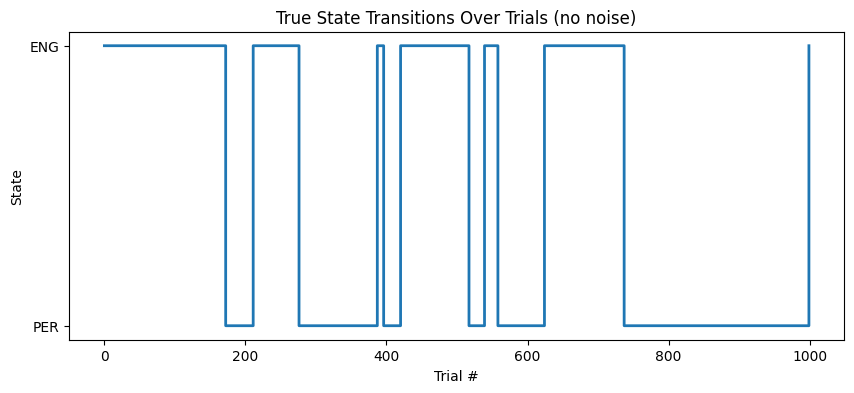

In [ ]:
state_numeric_no_noise = [1 if state == "ENG" else 0 for state in states]

plt.figure(figsize=(10, 4))
plt.step(range(len(state_numeric_no_noise)), state_numeric_no_noise, where='post', linewidth=2)
plt.yticks([0, 1], ['PER', 'ENG'])
plt.xlabel('Trial #')
plt.ylabel('State')
plt.title('True State Transitions Over Trials (no noise)')
plt.show()

In [ ]:
observer_params = {
    'kernel': ['random'],  # Random kernel
    'internal_noise_std': [1],  # Noise level
    'criteria': [0],  # Decision threshold
    'transition_matrix': [[[0.9, 0.1], [0.2, 0.8]]]  # Transition probabilities
}

experiment_params = {
    'n_trials': [100],
    'external_noise_std': [100],
    'trial_type': [Int2Trial],  # Replace with your trial type
    'n_features': [6]
}

analyser_params = {
    'internal_noise_extractor': [DoublePass],
    'model_file': ['agreement_model_large.csv']
}

sim = Sim(SimpleExperiment,experiment_params,
          PerseveratingObserver,observer_params,
            InternalNoiseValue,analyser_params)

results = sim.run_all(n_runs=10, multiprocess=False)
print(results)


  0%|          | 0/10 [00:00<?, ?it/s]


ValueError: no model file provided for AgreementMethod

In [ ]:

# Define the observer parameters, experiment parameters, and analyser parameters
observer_params = {
    'kernel': ['random'],  # Use a random kernel for simplicity
    'internal_noise_std': np.arange(1,5,0.5),  # Test different levels of internal noise
    'criteria': [0],  # Threshold criteria for decision-making
    'transition_matrix': [[[0.99, 0.01], [0.02, 0.98]]]
}

experiment_params = {
    'n_trials': [150],  # Number of trials per experiment
    'trial_type': [Int2Trial],  # The type of trial (assuming 'Int2Trial' is defined elsewhere)
    'n_features': [7],  # Number of features used in the experiment
    'external_noise_std': [100]  # Standard deviation of external noise
}

analyser_params = {
    'kernel_extractor': [GLMKernel],  # Use GLMModel to extract kernel
    'distance': ['CORR']  # Type of distance metric to use for analysis
}

# Initialize the simulation with the PerseveratingObserver
sim = Sim(SimpleExperiment, experiment_params, 
                 PerseveratingObserver, observer_params, 
                 KernelDistance, analyser_params)

# Run the simulation for all parameter configurations with multiple runs
sim_df = sim.run_all(n_runs=3, multiprocess=False)
sim_df

Processing config 7 run 2: 100%|██████████| 24/24 [00:00<00:00, 50.57it/s]


,config,n_trials,trial_type,n_features,external_noise_std,kernel,internal_noise_std,criteria,transition_matrix,kernel_extractor,distance,run,corr
0,0,150,<class 'palin.simulation.trial.Int2Trial'>,7,100,random,1.0,0,"[[0.99, 0.01], [0.02, 0.98]]",<class 'palin.kernels.glm_kernel.GLMKernel'>,CORR,0,0.417808
1,0,150,<class 'palin.simulation.trial.Int2Trial'>,7,100,random,1.0,0,"[[0.99, 0.01], [0.02, 0.98]]",<class 'palin.kernels.glm_kernel.GLMKernel'>,CORR,1,0.960516
2,0,150,<class 'palin.simulation.trial.Int2Trial'>,7,100,random,1.0,0,"[[0.99, 0.01], [0.02, 0.98]]",<class 'palin.kernels.glm_kernel.GLMKernel'>,CORR,2,0.866829
3,1,150,<class 'palin.simulation.trial.Int2Trial'>,7,100,random,1.5,0,"[[0.99, 0.01], [0.02, 0.98]]",<class 'palin.kernels.glm_kernel.GLMKernel'>,CORR,0,0.558602
4,1,150,<class 'palin.simulation.trial.Int2Trial'>,7,100,random,1.5,0,"[[0.99, 0.01], [0.02, 0.98]]",<class 'palin.kernels.glm_kernel.GLMKernel'>,CORR,1,0.935300
5,1,150,<class 'palin.simulation.trial.Int2Trial'>,7,100,random,1.5,0,"[[0.99, 0.01], [0.02, 0.98]]",<class 'palin.kernels.glm_kernel.GLMKernel'>,CORR,2,0.954427
6,2,150,<class 'palin.simulation.trial.Int2Trial'>,7,100,random,2.0,0,"[[0.99, 0.01], [0.02, 0.98]]",<class 'palin.kernels.glm_kernel.GLMKernel'>,CORR,0,0.186954
7,2,150,<class 'palin.simulation.trial.Int2Trial'>,7,100,random,2.0,0,"[[0.99, 0.01], [0.02, 0.98]]",<class 'palin.kernels.glm_kernel.GLMKernel'>,CORR,1,0.907876
8,2,150,<class 'palin.simulation.trial.Int2Trial'>,7,100,random,2.0,0,"[[0.99, 0.01], [0.02, 0.98]]",<class 'palin.kernels.glm_kernel.GLMKernel'>,CORR,2,0.848020
9,3,150,<class 'palin.simulation.trial.Int2Trial'>,7,100,random,2.5,0,"[[0.99, 0.01], [0.02, 0.98]]",<class 'palin.kernels.glm_kernel.GLMKernel'>,CORR,0,0.885190


In [ ]:
stim_values_1 = sim_combined_df.iloc[0]['stim_values']  # Shape: (150, 2, 7)
responses_1 = np.array(sim_combined_df.iloc[0]['responses'])      # Shape: (150,)
last_state_sequence_1 = sim_combined_df.iloc[0]['last_state_sequence']  # Shape: (150,)


# Extracting inputs for the first observer
inputs_1 = []
for num_trial, trial in enumerate(stim_values_1):
    stim_1 = np.array(trial[0])  # First stimulus
    stim_2 = np.array(trial[1])  # Second stimulus
    trial_diffs = stim_2 - stim_1  # Calculate differences between the two stimuli
    inputs_1.append(trial_diffs)


# Convert inputs and choice history to numpy arrays
inputs_array_1 = np.array(inputs_1)


# Adjusting choice history arrays using shifted responses
choice_history_array_no_noise = pd.Series(responses_1).shift(1).fillna(0).values.reshape(-1, 1)

# Combine inputs and choice history
inputs_array_no_noise = np.hstack((inputs_array_1, choice_history_array_no_noise))

# Convert responses to numpy arrays
responses_no_noise_array = responses_1.reshape(-1, 1)

# Display the inputs and responses
print(inputs_array_no_noise)



## Fit GLM-HMM and perform recovery analysis: Maximum Likelihood Estimation

In [ ]:
glm_no_noise = ssm.HMM(1, 1, 8, observations="input_driven_obs", 
                   observation_kwargs=dict(C=2), transitions="standard")
print(glm_no_noise.observations.params)
print(glm_no_noise.transitions.params)
ll_glm_no_noise=glm_no_noise.fit(responses_no_noise_array, inputs=inputs_array_no_noise, method="em", num_iters=100, tolerance=10**-3)

[[[ 1.8219206   0.29446416  0.74097108 -0.4126072  -1.65719116
    0.94903128  0.92008132 -1.11657212]]]
(array([[0.]]),)


Converged to LP: -154.1:   1%|          | 1/100 [00:01<01:39,  1.01s/it]


In [ ]:
npr.seed(0)
# Set the parameters of the GLM-HMM
num_states = 2        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 8         # input dimensions

In [ ]:
glmhmm_no_noise = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")
N_iters = 1000 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll_no_noise = glmhmm_no_noise.fit(responses_no_noise_array, inputs=inputs_array_no_noise, method="em", num_iters=N_iters, tolerance=10**-4)

Converged to LP: -214.1:   6%|▌         | 60/1000 [00:01<00:22, 42.22it/s]


In [ ]:
glm_weights_state_no_noise=glmhmm_no_noise.observations.params
glm_weights_state_1_no_noise = glmhmm_no_noise.observations.params[0]  
glm_weights_state_2_no_noise = glmhmm_no_noise.observations.params[1] 



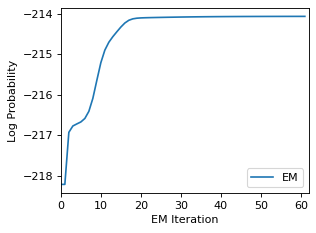

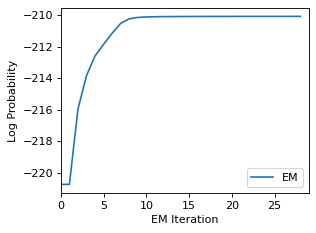

In [ ]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll_no_noise, label="EM")
#plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll_no_noise))
plt.ylabel("Log Probability")
plt.show()



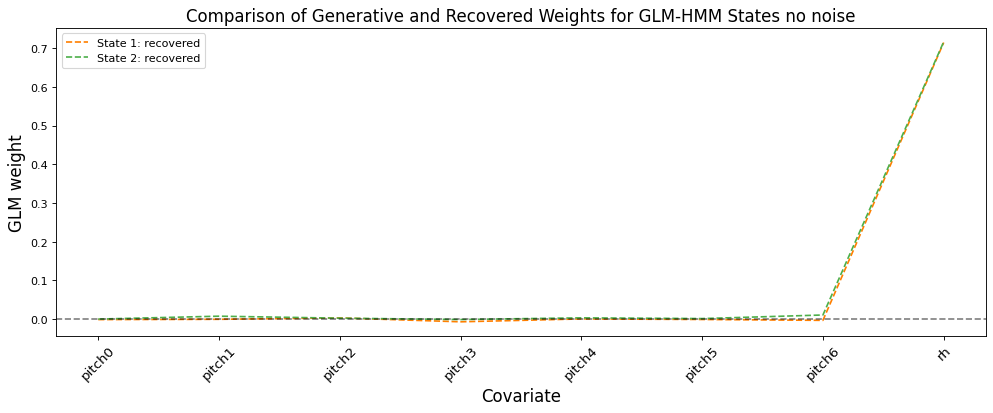

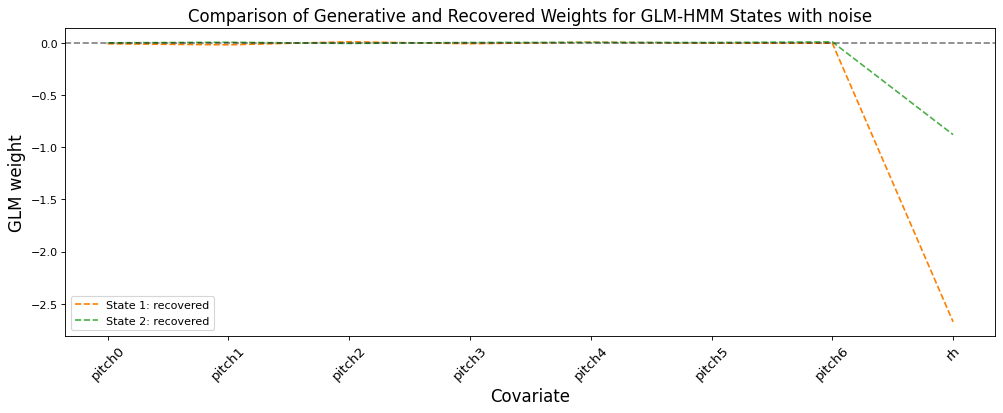

In [ ]:
fig = plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8','#984ea3'] 
recovered_weights_no_noise = (glmhmm_no_noise.observations.params)
for k in range(num_states):
    plt.plot(range(input_dim), (recovered_weights_no_noise[k][0])[:], color=cols[k],
             lw=1.5, label=f"State {k+1}: recovered", linestyle='--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("Covariate", fontsize=15)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.xticks(range(input_dim), ['pitch0', 'pitch1', 'pitch2', 'pitch3', 'pitch4', 'pitch5','pitch6','rh'], 
           fontsize=12, rotation=45)
plt.legend()
plt.title("Comparison of Generative and Recovered Weights for GLM-HMM States no noise", fontsize=15)
plt.show()



Text(0.5, 1.0, 'recovered')

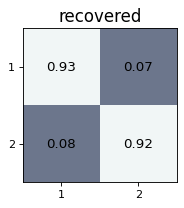

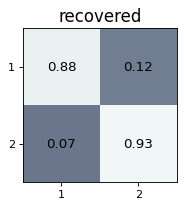

In [ ]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
recovered_trans_mat_no_noise= np.exp(glmhmm_no_noise.transitions.log_Ps)
plt.imshow(recovered_trans_mat_no_noise, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat_no_noise.shape[0]):
    for j in range(recovered_trans_mat_no_noise.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat_no_noise[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered", fontsize = 15)



Text(0, 0.5, 'observation class')

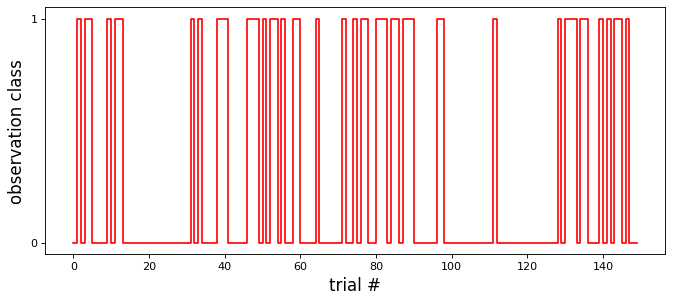

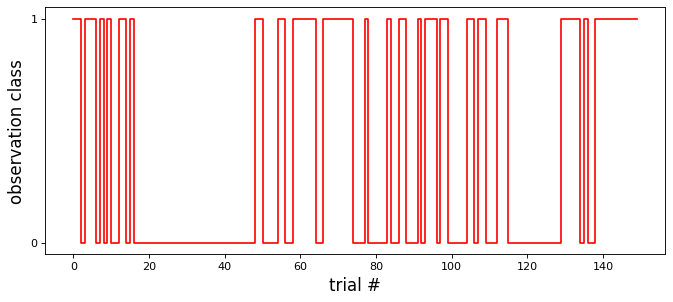

In [ ]:
fig = plt.figure(figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.step(range(150),responses_no_noise_array[range(150)], color = "red")
plt.yticks([0, 1])
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("observation class", fontsize = 15)



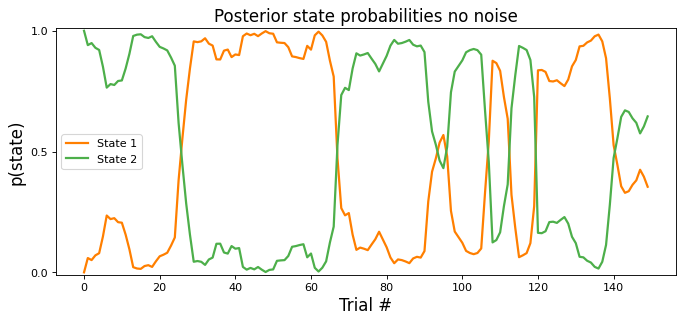

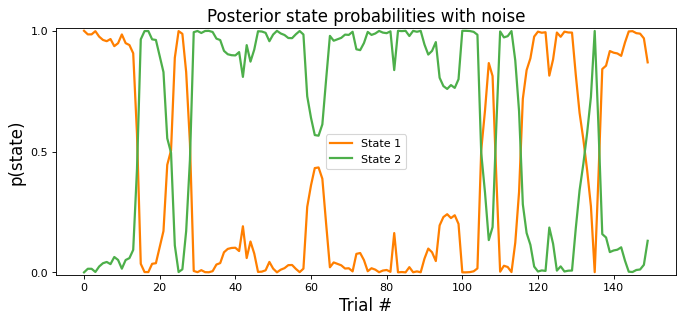

In [ ]:
fig = plt.figure(figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
posterior_probs_no_noise = glmhmm_no_noise.expected_states(data=responses_no_noise_array, input=inputs_array_no_noise)[0]
num_states = posterior_probs_no_noise.shape[1]  
for k in range(num_states):
    plt.plot(posterior_probs_no_noise[:, k], label="State " + str(k + 1), lw=2, color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize=10)
plt.xlabel("Trial #", fontsize=15)
plt.ylabel("p(state)", fontsize=15)
plt.title("Posterior state probabilities no noise", fontsize = 15)
plt.legend()
plt.show()



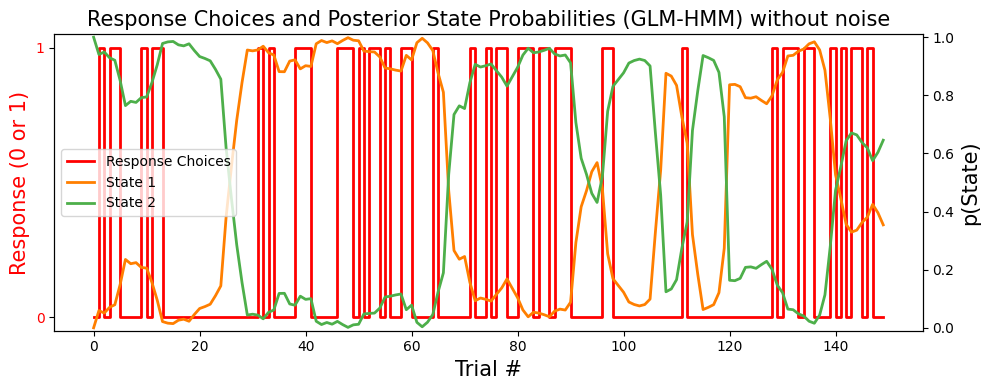

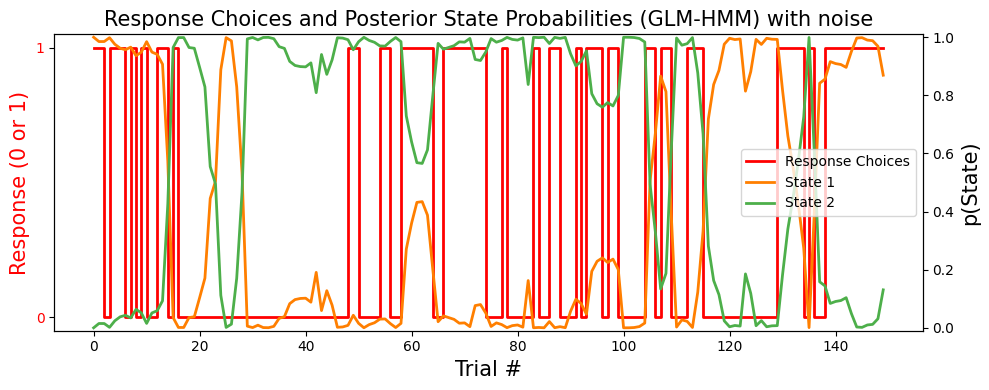

In [ ]:
cols = ['#ff7f00', '#4daf4a', '#377eb8','#984ea3']
fig, ax1 = plt.subplots(figsize=(10, 4), facecolor='w', edgecolor='k')
ax1.step(range(len(responses_no_noise_array)), responses_no_noise_array, color="red", label="Response Choices", lw=2)
ax1.set_yticks([0, 1])
ax1.set_title("Response Choices and Posterior State Probabilities (GLM-HMM) without noise", fontsize=15)
ax1.set_xlabel("Trial #", fontsize=15)
ax1.set_ylabel("Response (0 or 1)", fontsize=15, color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax2 = ax1.twinx()
for k in range(num_states):
    ax2.plot(range(len(responses_no_noise_array)), posterior_probs_no_noise[:, k], label="State " + str(k + 1), lw=2, color=cols[k])
ax2.set_ylim((-0.01, 1.01))
ax2.set_ylabel("p(State)", fontsize=15)
ax2.tick_params(axis='y')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2)
plt.tight_layout()
plt.show()


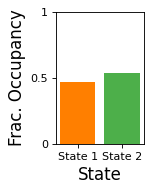

In [ ]:
cols = ['#ff7f00', '#4daf4a', '#377eb8', '#984ea3']
posterior_probs_concat_no_noise = np.vstack(posterior_probs_no_noise) 
state_max_posterior_no_noise = np.argmax(posterior_probs_concat_no_noise, axis=1)
_, state_occupancies_no_noise = np.unique(state_max_posterior_no_noise, return_counts=True)
state_occupancies_no_noise = state_occupancies_no_noise / np.sum(state_occupancies_no_noise)
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies_no_noise):
    plt.bar(z, occ, width=0.8, color=cols[z]) 
plt.ylim((0, 1))
plt.xticks([0, 1], ['State 1', 'State 2'], fontsize=10)  
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('State', fontsize=15)
plt.ylabel('Frac. Occupancy', fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
#state_numeric_no_noise = [1 if state == "ENG" else 0 for state in saved_states_no_noise]
posterior_probs_no_noise = glmhmm_no_noise.expected_states(data=responses_no_noise_array, input=inputs_array_no_noise)[0]
predicted_states_no_noise = np.argmax(posterior_probs_no_noise, axis=1)
rmse_no_noise = np.sqrt(mean_squared_error(state_numeric_no_noise, predicted_states_no_noise))

print("RMSE (No Noise):", rmse_no_noise)


RMSE (No Noise): 0.7071067811865476
RMSE (With Noise): 0.6324555320336759


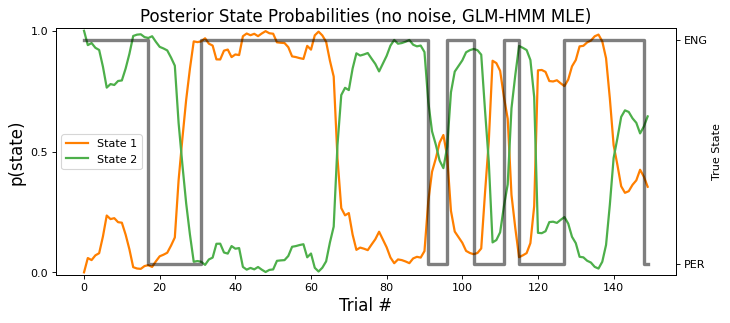

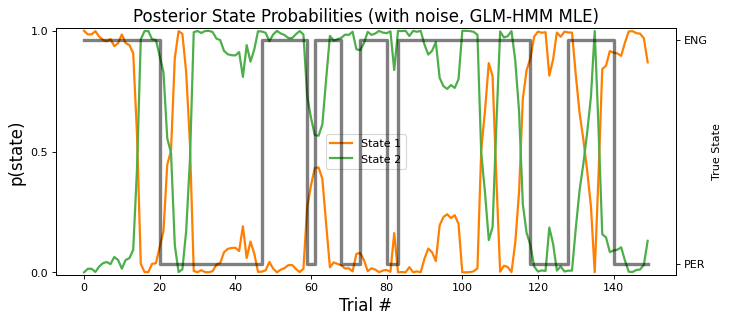

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
posterior_probs_no_noise = glmhmm_no_noise.expected_states(data=responses_no_noise_array, input=inputs_array_no_noise)[0]
num_states = posterior_probs_no_noise.shape[1]
for k in range(num_states):
    ax1.plot(posterior_probs_no_noise[:, k], label="State " + str(k + 1) , lw=2, color=cols[k])

ax1.set_ylim((-0.01, 1.01))
ax1.set_yticks([0, 0.5, 1])
ax1.set_xlabel("Trial #", fontsize=15)
ax1.set_ylabel("p(state)", fontsize=15)
ax1.set_title("Posterior State Probabilities (no noise, GLM-HMM MLE)", fontsize=15)
ax1.legend()

ax2 = ax1.twinx()
ax2.step(range(len(state_numeric_no_noise)), state_numeric_no_noise, where='post', linewidth=3, color='black', alpha=0.5)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['PER', 'ENG'])
ax2.set_ylabel('True State')

plt.show()


Best RMSE: 0.3
Best Parameters:
  Means: [(0, 1), (0, 0)]
  Sigmas: [(0.01, 2.505), (3.7525, 0.01)]
  Alpha: 1.0


Converged to LP: -80.7:   4%|▍         | 21/500 [00:00<00:09, 48.21it/s]


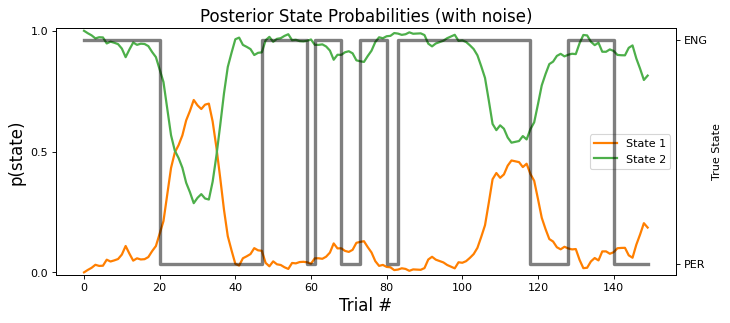

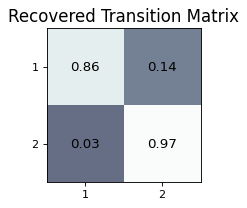

In [ ]:
# Set the parameters of the GLM-HMM
npr.seed(0)
num_states = 2        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 8         # input dimensions

# Define reduced ranges for prior means, sigmas, and alpha to speed up the grid search
mean_range_1 = [1]#np.linspace(-1, 1, 3)  # Reduced range for first state mean
mean_range_2 = [0]#np.linspace(-1, 1, 3)  # Reduced range for second state mean
sigma_range_1 = np.linspace(0.01, 5, 5)  # Reduced range for first state sigma
sigma_range_2 = np.linspace(0.01, 5, 5)  # Reduced range for second state sigma
alpha_range = np.linspace(1, 2, 20)  # Reduced range for alpha values

best_rmse = float('inf')
best_params = None

# Function to fit the model and calculate RMSE
def fit_glmhmm(mean_value_1, mean_value_2, sigma_value_1, sigma_value_2, alpha_value):
    # Ensure different values for mean_1 and mean_2, sigma_1 and sigma_2
    if mean_value_1 == mean_value_2 or sigma_value_1 == sigma_value_2:
        return float('inf'), None

    prior_means = [(0, mean_value_1), (mean_value_2, 0)]
    prior_sigmas = [(0.01, sigma_value_1), (sigma_value_2, 0.01)]
    prior_alpha = alpha_value

    # Instantiate the GLM-HMM
    map_glmhmm_no_noise = ssm.HMM(
        num_states, obs_dim, input_dim,
        observations="ind_input_driven_obs",
        observation_kwargs=dict(C=2, prior_means=prior_means, prior_sigmas=prior_sigmas),
        transitions="sticky", transition_kwargs=dict(alpha=prior_alpha, kappa=0)
    )

    # Fit the model using EM with MAP estimation
    fit_map_no_noise = map_glmhmm_no_noise.fit(
        responses_no_noise_array, inputs=inputs_array_no_noise, method="em", num_iters=500, tolerance=1e-4
    )

    # Extract predicted states and calculate RMSE
    posterior_probs_map_no_noise = map_glmhmm_no_noise.expected_states(
        data=responses_no_noise_array, input=inputs_array_no_noise
    )[0]
    predicted_states_no_noise_map = np.argmax(posterior_probs_map_no_noise, axis=1)

    # Convert saved states to numerical format (assuming saved_states_with_noise are available)
    state_numeric_no_noise_map = [1 if state == "ENG" else 0 for state in last_state_sequence_2]
    #rmse = -fit_map_no_noise[-1]
    rmse = np.mean(predicted_states_no_noise_map != state_numeric_no_noise_map)
    #rmse = np.sqrt(mean_squared_error(state_numeric_no_noise_map, predicted_states_no_noise_map))

    return rmse, (prior_means, prior_sigmas, prior_alpha)

# Run the grid search in parallel
results = Parallel(n_jobs=-1)(
    delayed(fit_glmhmm)(mean_value_1, mean_value_2, sigma_value_1, sigma_value_2, alpha_value)
    for mean_value_1 in mean_range_1
    for mean_value_2 in mean_range_2
    for sigma_value_1 in sigma_range_1
    for sigma_value_2 in sigma_range_2
    for alpha_value in alpha_range
)

# Find the best parameters and RMSE
for rmse, params in results:
    if rmse < best_rmse and params is not None:
        best_rmse = rmse
        best_params = params

print("Best RMSE:", best_rmse)
print("Best Parameters:")
print("  Means:", best_params[0])
print("  Sigmas:", best_params[1])
print("  Alpha:", best_params[2])

# Posterior probabilities for each trial with the best parameters
prior_means, prior_sigmas, prior_alpha = best_params
map_glmhmm_no_noise = ssm.HMM(
    num_states, obs_dim, input_dim,
    observations="ind_input_driven_obs",
    observation_kwargs=dict(C=2, prior_means=prior_means, prior_sigmas=prior_sigmas),
    transitions="sticky", transition_kwargs=dict(alpha=prior_alpha, kappa=0)
)

# Fit the model using EM with MAP estimation
fit_map_no_noise = map_glmhmm_no_noise.fit(
    responses_no_noise_array, inputs=inputs_array_no_noise, method="em", num_iters=500, tolerance=1e-4
)

# Extract GLM weights after fitting
map_glm_weights_state_no_noise = map_glmhmm_no_noise.observations.params

# Posterior probabilities for each trial
posterior_probs_map_no_noise = map_glmhmm_no_noise.expected_states(
    data=responses_no_noise_array, input=inputs_array_no_noise
)[0]

# Plot posterior state probabilities for each trial (with noise)
cols = ['#ff7f00', '#4daf4a', '#377eb8', '#984ea3']
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')

num_states = posterior_probs_map_no_noise.shape[1]
for k in range(num_states):
    ax1.plot(posterior_probs_map_no_noise[:, k], label="State " + str(k + 1), lw=2, color=cols[k])

ax1.set_ylim((-0.01, 1.01))
ax1.set_yticks([0, 0.5, 1])
ax1.set_xlabel("Trial #", fontsize=15)
ax1.set_ylabel("p(state)", fontsize=15)
ax1.set_title("Posterior State Probabilities (with noise)", fontsize=15)
ax1.legend()

# Plot true states (with noise) on the secondary y-axis
ax2 = ax1.twinx()
state_numeric_no_noise_map = [1 if state == "ENG" else 0 for state in last_state_sequence_2]
ax2.step(range(len(state_numeric_no_noise_map)), state_numeric_no_noise_map, where='post', linewidth=3, color='black', alpha=0.5)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['PER', 'ENG'])
ax2.set_ylabel('True State')

plt.show()

# Plot the recovered transition matrix for the best parameters
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
map_recovered_trans_mat_no_noise = np.exp(map_glmhmm_no_noise.transitions.log_Ps)
plt.imshow(map_recovered_trans_mat_no_noise, vmin=-0.8, vmax=1, cmap='bone')
for i in range(map_recovered_trans_mat_no_noise.shape[0]):
    for j in range(map_recovered_trans_mat_no_noise.shape[1]):
        text = plt.text(j, i, str(np.around(map_recovered_trans_mat_no_noise[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("Recovered Transition Matrix", fontsize=15)
plt.show()

## BO GLM-HMM

In [ ]:
num_states = 2        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 8         # input dimensions

best_rmse = float('inf')
best_params = None

# Function to fit the model and calculate RMSE and residuals
def fit_glmhmm(params, responses, inputs, saved_states):
    mean_value_1, mean_value_2, sigma_value_1, sigma_value_2, alpha_value = params

    prior_means = [(0, mean_value_1), (mean_value_2, 0)]
    prior_sigmas = [(0.01, sigma_value_1), (sigma_value_2, 0.01)]
    prior_alpha = alpha_value

    # Instantiate the GLM-HMM
    map_glmhmm = ssm.HMM(
        num_states, obs_dim, input_dim,
        observations="ind_input_driven_obs",
        observation_kwargs=dict(C=num_categories, prior_means=prior_means, prior_sigmas=prior_sigmas),
        transitions="sticky", transition_kwargs=dict(alpha=prior_alpha, kappa=0)
    )

    # Fit the model using EM with MAP estimation
    map_glmhmm.fit(responses, inputs=inputs, method="em", num_iters=200, tolerance=1e-3)

    # Extract predicted states and calculate RMSE
    posterior_probs = map_glmhmm.expected_states(data=responses, input=inputs)[0]
    predicted_states = np.argmax(posterior_probs, axis=1)

    # Convert saved states to numerical format (assuming saved_states are available)
    state_numeric = [1 if state == "ENG" else 0 for state in saved_states]
    
    # Calculate RMSE for all states
    # Calculate total mismatch rate (binary classification error rate)
    rmse_total = np.mean(predicted_states != state_numeric)

# Calculate mismatch rate separately for PER and ENG states
# PER (state 0)
    per_indices = [i for i, state in enumerate(state_numeric) if state == 0]
    if len(per_indices) > 0:
        rmse_per = np.mean(predicted_states[per_indices] != np.array(state_numeric)[per_indices])
    else:
        rmse_per = np.nan  # No PER trials to calculate mismatch rate for

# ENG (state 1)
    eng_indices = [i for i, state in enumerate(state_numeric) if state == 1]
    if len(eng_indices) > 0:
        rmse_eng = np.mean(predicted_states[eng_indices] != np.array(state_numeric)[eng_indices])
    else:
        rmse_eng = np.nan  # No ENG trials to calculate mismatch rate for

    # Calculate the log likelihood of the fitted model
    log_likelihood = map_glmhmm.log_likelihood(responses, inputs=inputs)

    return rmse_total, rmse_per, rmse_eng, log_likelihood, (prior_means, prior_sigmas, prior_alpha), \
           predicted_states, posterior_probs, \
           map_glmhmm.observations.params[0], map_glmhmm.observations.params[1], \
           np.exp(map_glmhmm.transitions.log_Ps)

# Define the optimization space
space = [
    Real(0.0, 2.0, name='mean_value_1'),
    Real(0.0, 2.0, name='mean_value_2'),
    Real(1.0, 5.0, name='sigma_value_1'),
    Real(1.0, 5.0, name='sigma_value_2'),
    Real(1.0, 3.0, name='alpha_value')
]

# Optimization function for Bayesian Optimization
def objective(params):
    rmse_total, *_ = fit_glmhmm(params, responses, inputs, saved_states)
    return rmse_total

# Iterate over each simulation result in sim_combined_df
glm_hmm_results2 = []
posterior_probabilities_list = []
observed_states_list = []
glm_weights_list = []

for idx in range(len(sim_combined_df)):
    responses = responses_list[idx]
    inputs = inputs_list[idx]
    saved_states = saved_states_list[idx]

    # Run Bayesian optimization to find the best parameters
    result = gp_minimize(objective, space, n_calls=30, random_state=42)

    # Get the best parameters and fit the model again to extract details
    best_params = result.x
    best_rmse_total, best_rmse_per, best_rmse_eng, log_likelihood, best_params_full, best_states, \
    best_posterior_probs, best_glm_weights_state_1, best_glm_weights_state_2, transitions_log_ps = fit_glmhmm(
        best_params, responses, inputs, saved_states
    )

    # Append posterior probabilities, observed states, and GLM weights for plotting
    posterior_probabilities_list.append(best_posterior_probs)
    observed_states_list.append(saved_states)
    glm_weights_list.append((best_glm_weights_state_1, best_glm_weights_state_2))

    # Append the results to the global list, including RMSE for each state and log likelihood
    glm_hmm_results2.append({
        'simulation_index': idx,
        'best_rmse_total': best_rmse_total,
        'best_rmse_per': best_rmse_per,
        'best_rmse_eng': best_rmse_eng,
        'log_likelihood': log_likelihood,
        'best_prior_alpha': best_params_full[2],
        'best_prior_sigma_1': best_params_full[1][0][1],
        'best_prior_sigma_2': best_params_full[1][1][0],
        'best_mean_value_1': best_params_full[0][0][1],  
        'best_mean_value_2': best_params_full[1][1][0],
        'best_posterior_probs': best_posterior_probs,
        'glm_weights_state_1': best_glm_weights_state_1,
        'glm_weights_state_2': best_glm_weights_state_2,
        'transitions_log_ps': transitions_log_ps,
    })

    # Save intermediate results to a pickle file
    with open('intermediate_glm_hmm_results4.pkl', 'wb') as f:
        pickle.dump(glm_hmm_results2, f)

# Convert results to DataFrame
results_df_new2 = pd.DataFrame(glm_hmm_results2)

Converged to LP: -85.1:  13%|█▎        | 26/200 [00:00<00:02, 68.60it/s]


In [ ]:
with open('intermediate_glm_hmm_results4.pkl', 'rb') as f:
    glm_hmm_results2 = pickle.load(f)

# Now glm_hmm_results2 contains the data you saved
results_df_new2 = pd.DataFrame(glm_hmm_results2)
results_df_new2

,simulation_index,best_rmse_total,best_rmse_per,best_rmse_eng,log_likelihood,best_prior_alpha,best_prior_sigma_1,best_prior_sigma_2,best_mean_value_1,best_mean_value_2,best_posterior_probs,glm_weights_state_1,glm_weights_state_2,transitions_log_ps
0,0,0.206667,0.057143,0.252174,-84.450538,2.020965,5.000000,1.000000,0.000000,1.000000,"[[0.0007105203501973209, 0.9992894796498084], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.093060...","[[-0.000406752041164255, -0.01116133824190002,...","[[0.7510572516415087, 0.24894274835849148], [0..."
1,1,0.080000,0.000000,0.157895,-65.438100,2.984423,4.754211,1.003115,0.112823,1.003115,"[[1.3307749127468854e-09, 0.9999999986692245],...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.253388...","[[-4.100732083316529e-05, -0.00292467252122322...","[[0.9091136575673868, 0.0908863424326134], [0...."
2,2,0.106667,0.619048,0.023256,-79.890779,1.004107,3.774426,3.983458,1.606395,3.983458,"[[0.0034424057594908955, 0.9965575942405118], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.265627...","[[-0.0020271863935179732, 0.005041766628853028...","[[0.7484684385752748, 0.25153156142472544], [0..."
3,3,0.213333,0.451613,0.045455,-80.761133,1.000000,5.000000,5.000000,0.775258,5.000000,"[[0.9999980271306433, 1.9728693500617785e-06],...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -4.236589...","[[0.0009396728579597975, -0.004240397483797019...","[[0.8282978997812636, 0.17170210021873658], [0..."
4,4,0.473333,0.769231,0.247059,-86.203811,2.301777,2.334834,1.571467,0.199950,1.571467,"[[1.8988238206046125e-08, 0.9999999810117688],...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.361599...","[[0.0009983032302522514, -0.005024857196131735...","[[0.32771614162874074, 0.6722838583712596], [0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,76,0.206667,0.396226,0.103093,-84.163758,2.984423,4.754211,1.003115,0.112823,1.003115,"[[0.9854723760067944, 0.014527623993210493], [...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -4.698006...","[[-5.6479779066997145e-06, -0.0003588430282208...","[[0.7540657118033278, 0.24593428819667232], [0..."
77,77,0.253333,0.489362,0.145631,-93.541765,1.891666,4.118764,3.387401,1.593086,3.387401,"[[0.9999240944428951, 7.590555710200632e-05], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.897993...","[[0.00019907361531033165, 0.000506928107091818...","[[0.8730640598191749, 0.12693594018082535], [0..."
78,78,0.280000,0.310811,0.250000,-81.263662,1.181213,4.895022,1.931085,0.799722,1.931085,"[[1.2763160694796882e-05, 0.9999872368393102],...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.434939...","[[-1.64314110553338e-05, 6.751448144411459e-05...","[[0.973588070490703, 0.026411929509297303], [0..."
79,79,0.193333,0.253333,0.133333,-85.330186,2.269760,5.000000,5.000000,1.661212,5.000000,"[[9.77993436832925e-09, 0.9999999902200614], [...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -4.343413...","[[1.6711269787736683e-05, -0.00010668608007463...","[[0.8246823090871218, 0.17531769091287833], [0..."


In [ ]:
# Set the parameters of the GLM-HMM
num_states = 3        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

# Make a GLM-HMM
true_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

In [ ]:
gen_weights = np.array([[[6, 1]], [[2, -3]], [[2, 3]]])
gen_log_trans_mat = np.log(np.array([[[0.98, 0.01, 0.01], [0.05, 0.92, 0.03], [0.03, 0.03, 0.94]]]))
true_glmhmm.observations.params = gen_weights
true_glmhmm.transitions.params = gen_log_trans_mat

Text(0.5, 1.0, 'Generative transition matrix')

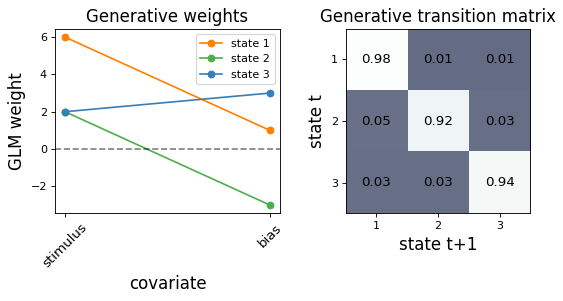

In [ ]:
# Plot generative parameters:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = ['#ff7f00', '#4daf4a', '#377eb8']
for k in range(num_states):
    plt.plot(range(input_dim), gen_weights[k][0], marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Generative weights", fontsize = 15)

plt.subplot(1, 2, 2)
gen_trans_mat = np.exp(gen_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)

In [ ]:
num_sess = 20 # number of example sessions
num_trials_per_sess = 100 # number of trials in a session
inpts = np.ones((num_sess, num_trials_per_sess, input_dim)) # initialize inpts array
stim_vals = [-1, -0.5, -0.25, -0.125, -0.0625, 0, 0.0625, 0.125, 0.25, 0.5, 1]
inpts[:,:,0] = np.random.choice(stim_vals, (num_sess, num_trials_per_sess)) # generate random sequence of stimuli
inpts = list(inpts) #convert inpts to correct format

In [ ]:
# Generate a sequence of latents and choices for each session
true_latents, true_choices = [], []
for sess in range(num_sess):
    true_z, true_y = true_glmhmm.sample(num_trials_per_sess, input=inpts[sess])
    true_latents.append(true_z)
    true_choices.append(true_y)

In [ ]:
# Calculate true loglikelihood
true_ll = true_glmhmm.log_probability(true_choices, inputs=inpts) 
print("true ll = " + str(true_ll))

true ll = -910.987989460021


generate simulated responses from a simple observer with noise

In [309]:
observed_noise_std=1.1
n_trials = 150
exp = DoublePassExperiment(n_trials = n_trials,n_repeated=n_trials, 
                       trial_type = Int2Trial, 
                       n_features = 6, 
                       external_noise_std = 100)
obs = LinearObserver.with_random_kernel(n_features = exp.n_features,
                                        internal_noise_std = observed_noise_std, 
                                        criteria = 0)
responses = obs.respond_to_experiment(exp)
responses_df = Analyser.to_df(exp, responses)
responses_df

,trial,stim,feature,value,response
0,0,0,0,-48.706496,True
1,0,0,1,20.833937,True
2,0,0,2,-8.022884,True
3,0,0,3,32.840460,True
4,0,0,4,39.567654,True
...,...,...,...,...,...
3595,299,1,1,-20.861168,True
3596,299,1,2,-82.528085,True
3597,299,1,3,108.384172,True
3598,299,1,4,151.647533,True


## Extract kernel

In [310]:
kernel_df, results = GLMKernel.extract_single_kernel(data_df=responses_df, feature_id='feature', value_id='value', response_id='response')
kernel_df=kernel_df.reset_index()
kernel_df['kernel_value'].values

array([-0.00169427,  0.01010364, -0.01636297, -0.00050427,  0.00663745,
        0.01366558])

## CI internal noise

In [311]:
ci_df = GLMKernel.get_confidence_intervals(results)
ci_df=ci_df.reset_index()
ci_df

,index,lower_bound,upper_bound
0,diff_value0,-0.004256,0.000868
1,diff_value1,0.006965,0.013242
2,diff_value2,-0.020486,-0.012240
3,diff_value3,-0.003286,0.002277
4,diff_value4,0.003967,0.009308
5,diff_value5,0.009822,0.017510


In [316]:
#group_cols = ['internal_noise_std', 'n_trials']
glm_method = GLMMethod()
# norm_max_feature_ci, kernel_df['conf_int'] = glm_method.extract_norm_max_feature_ci(kernel_df, ci_df)
norm_max_feature_ci, kernel_df['conf_int'] = glm_method.extract_norm_max_feature_ci(kernel_df, ci_df)

#glm_method.fit_ols([norm_max_feature_ci], [observed_noise_std])
norm_max_feature_ci

1.234426962486312

In [317]:
kernel_df['conf_int']

0    0.005124
1    0.006277
2    0.008246
3    0.005563
4    0.005341
5    0.007688
Name: conf_int, dtype: float64

## Test GLMKernel

In [7]:
exp = SimpleExperiment(n_trials = 500,
                       trial_type = Int2Trial, 
                       n_features = 6, 
                       external_noise_std = 100)
obs = LinearObserver.with_random_kernel(n_features = exp.n_features,
                                        internal_noise_std = 3, 
                                        criteria = 0)
responses = obs.respond_to_experiment(exp)
responses_df = Analyser.to_df(exp, responses)

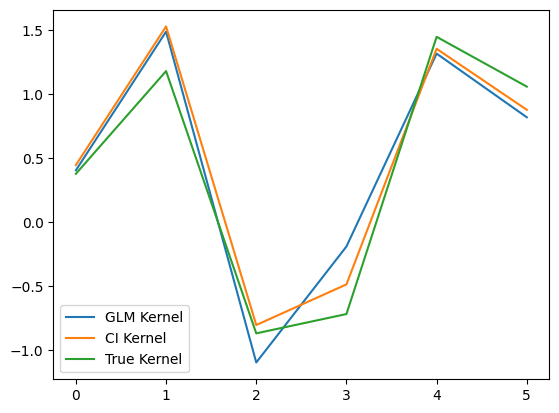

In [8]:
glm_kernel = GLMKernel.extract_single_kernel(data_df=responses_df, feature_id='feature', value_id='value', response_id='response')
ci_kernel = ClassificationImage.extract_single_kernel(data_df=responses_df, feature_id='feature', value_id='value', response_id='response')
plt.plot(GLMKernel.normalize_kernel(glm_kernel), label='GLM Kernel')
plt.plot(GLMKernel.normalize_kernel(ci_kernel), label='CI Kernel')
plt.plot(GLMKernel.normalize_kernel(obs.kernel), label='True Kernel')
plt.legend()



In [9]:
observer_params = {'kernel':['random'],
                   'internal_noise_std':np.arange(0,6.1,0.1), 
                  'criteria':[0]}
experiment_params = {'n_trials':[1000], 
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}
analyser_params = {'kernel_extractor':[ClassificationImage, GLMKernel]}        
                   
sim = Sim(SimpleExperiment, experiment_params, 
          LinearObserver, observer_params, 
          KernelDistance, analyser_params)
sim_df = sim.run_all(n_runs=10)

100%|██████████| 1220/1220 [00:05<00:00, 205.94it/s]


In [27]:
sim_df

,config,n_trials,trial_type,n_features,external_noise_std,kernel,internal_noise_std,criteria,kernel_extractor,run,corr
0,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.kernels.classification_images.Cl...,7,0.989799
1,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.kernels.classification_images.Cl...,9,0.996254
2,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.kernels.classification_images.Cl...,6,0.996972
3,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.kernels.classification_images.Cl...,3,0.993503
4,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.kernels.classification_images.Cl...,5,0.998589
...,...,...,...,...,...,...,...,...,...,...,...
1215,121,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,6.0,0,<class 'palin.kernels.glm_kernel.GLMKernel'>,2,0.989934
1216,121,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,6.0,0,<class 'palin.kernels.glm_kernel.GLMKernel'>,7,0.987563
1217,121,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,6.0,0,<class 'palin.kernels.glm_kernel.GLMKernel'>,6,0.992239
1218,121,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,6.0,0,<class 'palin.kernels.glm_kernel.GLMKernel'>,9,0.985724


<AxesSubplot: xlabel='internal_noise_std', ylabel='corr'>

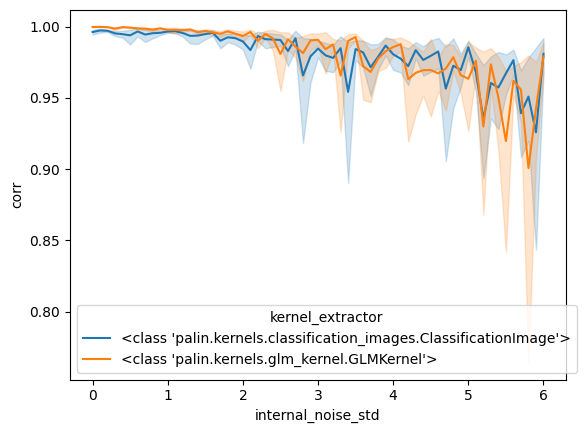

In [14]:
sns.lineplot(data=sim_df,
             x='internal_noise_std',
             y='corr',
             hue='kernel_extractor')

## Test GLMMethod

In [11]:
exp = SimpleExperiment(n_trials = 500,
                       trial_type = Int2Trial, 
                       n_features = 6, 
                       external_noise_std = 100)
obs = LinearObserver.with_random_kernel(n_features = exp.n_features,
                                        internal_noise_std = 3, 
                                        criteria = 0)
responses = obs.respond_to_experiment(exp)
responses_df = Analyser.to_df(exp, responses)

In [20]:
norm_ci_value = GLMMethod.extract_norm_ci_value(data_df=responses_df)
norm_ci_value

12.574688648860807

In [21]:
model = GLMMethod.build_model()
model

100%|██████████| 490/490 [00:03<00:00, 123.49it/s]


In [23]:
estimated_noise_CI = norm_ci_value * model.params[1] + model.params[0]
estimated_noise_CI

2.225598361014603

In [ ]:
GLMMethod.extract_single_internal_noise(responses_df, kernel_extractor=GLMKernel)

100%|██████████| 490/490 [00:05<00:00, 90.40it/s] 


2.2990789511549043

## Compare CI with IN double_pass

In [28]:
internal_noise_std = np.arange(0.3, 5, 0.5)
n_trials = np.arange(100, 1000, 100)
random_kernel=[1, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05]
results_fix = []

for n_trial in n_trials:
    exp = DoublePassExperiment(
        n_trials=n_trial,
        n_repeated=n_trial,
        trial_type=Int2Trial,
        n_features=7,
        external_noise_std=100
    )

    for noise in internal_noise_std:
        obs = LinearObserver(kernel=random_kernel,
                                 internal_noise_std=noise, 
                                 criteria=0)
        responses = obs.respond_to_experiment(exp)
        responses_df = Analyser.to_df(exp, responses)

        estimated_noise_CI=GLMMethod.extract_single_internal_noise(responses_df, kernel_extractor=GLMKernel)
        
        ana = InternalNoiseValue(internal_noise_extractor=DoublePass, model_file='model.csv')
        data = ana.analyse(exp, obs, responses)
        metrics = ana.get_metric_names()

        results_fix.append({
            'n_trials': n_trial,
            'internal_noise_std': noise,
            'estimated_noise_CI': estimated_noise_CI,
            metrics[0]: data[0],  
            metrics[1]: data[1]
        })
       
results_df = pd.DataFrame(results_fix)
results_df

100%|██████████| 490/490 [00:04<00:00, 100.95it/s]


,n_trials,internal_noise_std,estimated_noise_CI,estimated_internal_noise,estimated_criteria
0,100,0.3,2.124364,0.2,-2.000000e-01
1,100,0.8,1.594222,1.2,-1.000000e-01
2,100,1.3,1.572188,1.1,2.000000e-01
3,100,1.8,1.850936,0.6,2.000000e-01
4,100,2.3,2.101399,1.5,3.000000e-01
...,...,...,...,...,...
85,900,2.8,2.154651,3.3,-1.776357e-14
86,900,3.3,2.515100,3.4,9.000000e-01
87,900,3.8,2.653806,4.5,7.000000e-01
88,900,4.3,3.048628,3.9,-4.000000e-01


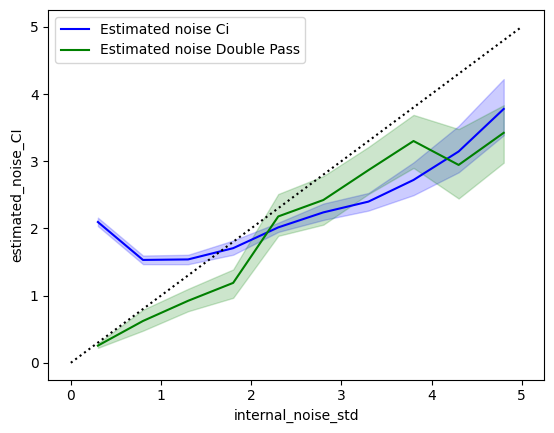

In [37]:
sns.lineplot(data=results_df, x='internal_noise_std', y='estimated_noise_CI', label='Estimated noise Ci', color='blue')
sns.lineplot(data=results_df, x='internal_noise_std', y='estimated_internal_noise', label='Estimated noise Double Pass', color='green')

plt.plot([0,5],[0,5],'k:')

<AxesSubplot: xlabel='internal_noise_std', ylabel='estimated_noise_CI'>

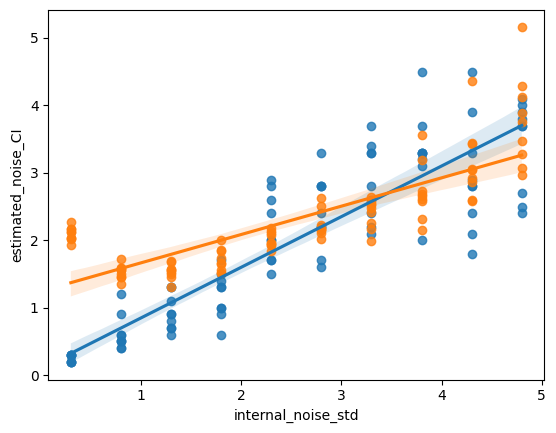

In [47]:
sns.regplot(data=results_df, x="internal_noise_std", y="estimated_internal_noise")
sns.regplot(data=results_df, x="internal_noise_std", y="estimated_noise_CI")


In [32]:
InternalNoiseValue(internal_noise_extractor=GLMMethod, kernel_extractor=GLMKernel).analyse(exp, obs, responses)

100%|██████████| 490/490 [00:04<00:00, 121.92it/s]


(4.195135621977944, None)

In [25]:
InternalNoiseValue(internal_noise_extractor=InterceptMethod, model_file='large_model.csv', kernel_extractor=ClassificationImage).analyse(exp, obs, responses)

ValueError: cannot insert response, already exists

In [ ]:
InterceptMethod.extract_single_internal_noise(responses_df, model_file='large_model.csv', kernel_extractor=ClassificationImage)

ValueError: cannot insert response, already exists

In [348]:
# InterceptMethod.extract_single_internal_noise(responses_df, model_file='large_model.csv', kernel_extractor=ClassificationImage)
# InternalNoiseValue(internal_noise_extractor=InterceptMethod, model_file='large_model.csv', kernel_extractor=ClassificationImage).analyse(exp, obs, responses)

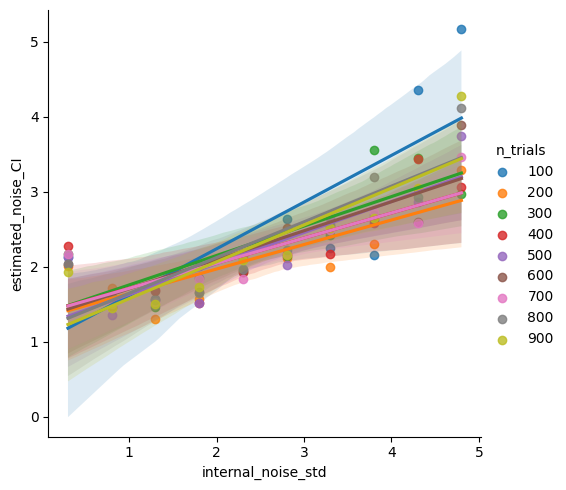

In [36]:
sns.lmplot(
   data=results_df,#[merged_df.n_trials > 200]
   x='internal_noise_std',
   y='estimated_noise_CI',
   hue='n_trials'
   #marker='o',
   #palette='viridis'
)

In [384]:
import statsmodels.formula.api as smf
model1 = smf.ols(formula="internal_noise_std ~ norm_max_feature_ci*n_trials", data=filtered_mean_ci_size_df).fit()
print(model1.params)
filtered_mean_ci_size_df['estimated_noise_CI'] = (filtered_mean_ci_size_df['norm_max_feature_ci'] * model1.params[1] + model1.params[0])

Intercept                      -1.052558
norm_max_feature_ci             0.440062
n_trials                       -0.001573
norm_max_feature_ci:n_trials    0.000159
dtype: float64


In [385]:
filtered_mean_ci_size_df

,internal_noise_std,n_trials,max_feature_ci,norm_max_feature_ci,estimated_internal_noise,estimated_criteria,estimated_noise_CI
0,0.8,100,0.756076,7.560758,0.5,0.3,2.274643
1,0.8,100,0.756076,7.560758,0.5,0.3,2.274643
2,0.8,100,0.756076,7.560758,0.5,0.3,2.274643
3,0.8,100,0.756076,7.560758,0.5,0.3,2.274643
4,0.8,100,0.756076,7.560758,0.5,0.3,2.274643
...,...,...,...,...,...,...,...
562,4.8,900,0.390879,11.726361,4.0,-0.4,4.107766
563,4.8,900,0.390879,11.726361,4.0,-0.4,4.107766
564,4.8,900,0.390879,11.726361,4.0,-0.4,4.107766
565,4.8,900,0.390879,11.726361,4.0,-0.4,4.107766


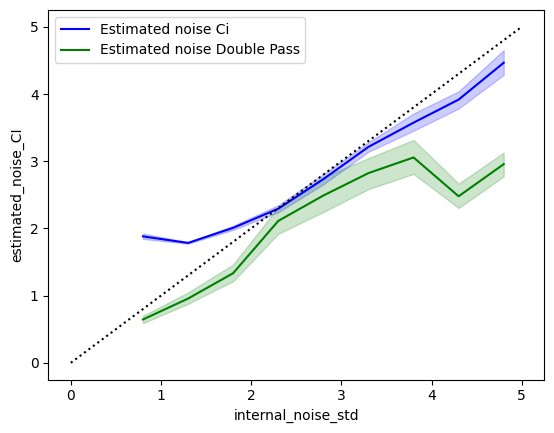

In [386]:
# sns.lineplot(data=filtered_mean_ci_size_df, x='internal_noise_std', y='norm_max_feature_ci', label='norm_max_feature_ci', color='red')
sns.lineplot(data=filtered_mean_ci_size_df, x='internal_noise_std', y='estimated_noise_CI', label='Estimated noise Ci', color='blue')
sns.lineplot(data=filtered_mean_ci_size_df, x='internal_noise_std', y='estimated_internal_noise', label='Estimated noise Double Pass', color='green')

plt.plot([0,5],[0,5],'k:')

## Intercept interval noise

In [85]:
InterceptMethod.compute_prob_agreement(responses_df,
                                       trial_id='trial',
                                       stim_id= 'stim',
                                       feature_id= 'feature',
                                       value_id = 'value',
                                       response_id='response',
                                       kernel_extractor=None)
        

0.7975201158150532

pivot dataframe to have one entry per trial

In [32]:
# group by trial and stim
df = responses_df.groupby(['trial','stim']).agg({'value':list, 'response':'first'}).reset_index()
df.value = df.value.apply(lambda x: np.array(x))
# for each trial, compute trial difference and which stim response
df = df.groupby(['trial']).agg({'value':lambda x:x.diff().iloc[1], #diff produces 2 lines, the first is nan
                           'response': lambda x: 0 if x.iloc[0] else 1}).reset_index()

What we need to compare is the projected difference on the kernel, i.e. if 2 trials are different in dimensions for which the kernel is null, then that difference doesn't matter

Generate all combinations of trials

In [33]:
from itertools import combinations
a, b = map(list, zip(*combinations(df.index, 2)))
comb_df = pd.concat(
    [df.loc[a].add_suffix('_1').reset_index(), df.loc[b].add_suffix('_2').reset_index()], axis=1, 
).drop(columns=['index'])

comb_df['value']=(comb_df.value_1 - comb_df.value_2)
# projected difference on the kernel (if 2 trials are different in dimensions for which the kernel is null, then that difference doesn't matter)
comb_df['proj_value']= comb_df.value.apply(lambda x: np.abs(x.dot(obs.kernel)))
# RMS of trial difference (i.e. trial difference of stim difference)
comb_df.value = comb_df.value.apply(lambda x: np.sqrt(np.sum(x**2)))
comb_df['agree']=(comb_df.response_1==comb_df.response_2).astype(int) 
comb_df = comb_df.drop(columns=['value_1','value_2','response_1','response_2'])

Relation between value & projected value is triangular: when value is small, proj_value can't be high; when value is high, proj_value can be whatever

<Axes: xlabel='value', ylabel='proj_value'>

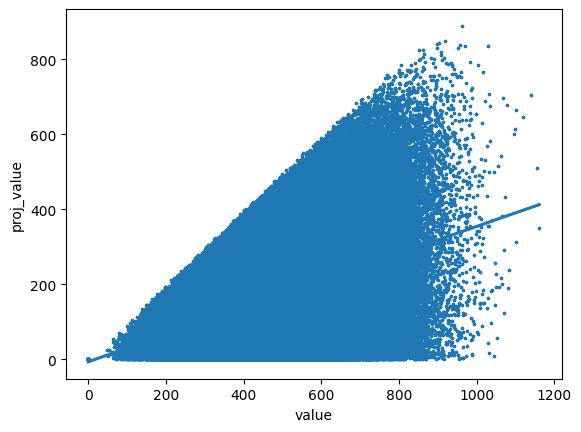

In [27]:
sns.regplot(data=comb_df, x='value',y='proj_value', scatter_kws={'s':2})

fit polynomial


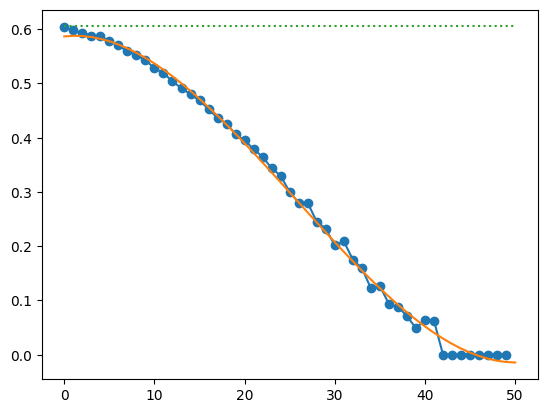

In [34]:
def binned_prob(data=comb_df, value='value',spacing='linear',nbins=100): 
    # get a separate bin for 0 (in case of double_pass)
    min_non_null = data[data[value]>0][value].min()
    if spacing == 'log': 
        bins = pd.cut(data[value],
                  bins=np.logspace(np.log10(min_non_null),
                                   np.log10(data[value].max()+1),nbins),
                  labels=False)
        bins = bins + 1 # increment all bins by 1
        bins = bins.fillna(0) # and give bin 0 to all that are < min_non_null 
    else: 
        bins = pd.cut(data[value],
                  bins=np.linspace(min_non_null,
                                   data[value].max()+1,nbins),
                  labels=False)
    bins = bins + 1 # increment all bins by 1
    bins = bins.fillna(0) # and give bin 0 to all that are < min_non_null 
    return data.groupby(bins).agree.mean().reset_index()
   
bins = binned_prob(comb_df,'proj_value',spacing='linear', nbins=50)
plt.plot(bins.proj_value, bins.agree, 'o-', label='proj linear')

#bins = binned_prob(comb_df,'value',spacing='linear',nbins=50)
#plt.plot(bins.value, bins.agree, 'o-', label='proj log')
#plt.legend()

print('fit polynomial')
try:
    poly = np.poly1d(np.polyfit(bins.proj_value[1:], bins.agree[1:], 3))
    plt.plot(x,poly(x), label='poly')
except RuntimeError: 
    print('fail')


# get p_agree groundtruth

p_agree, p_int1 = DoublePassStatistics().analyse(exp, obs, responses)
plt.plot([0,50],[p_agree,p_agree], ':')


In [29]:
from scipy.optimize import curve_fit
from scipy import stats

plt.plot(bins.proj_value, bins.agree, 'o', label='data')
x = np.linspace(0, 50, 50)

#popt, pcov = curve_fit(sigmoid, bins.proj_value, bins.agree, p0=[10,1])

#x = np.linspace(0, 50, 50)
#y = sigmoid(x, *popt)

#plt.plot(x,y, label='sigmoid')

print('fit exponential')
try: 
    def func(x, a, b, c):
        return a * np.exp(-b * x) + c
    popt, pcov = curve_fit(func, bins.proj_value[1:], bins.agree[1:])
    plt.plot(x,func(x, *popt), label='exp')
except RuntimeError: 
    print('fail')

print('fit polynomial')
try:
    poly = np.poly1d(np.polyfit(bins.proj_value[1:], bins.agree[1:], 3))
    plt.plot(x,poly(x), label='poly')
except RuntimeError: 
    print('fail')

print('fit logistics')
try:
    def sigmoid(x, L ,x0, k, b):
        return L / (1 + np.exp(-k*(x-x0))) + b
    popt, pcov = curve_fit(sigmoid, bins.proj_value[1:], bins.agree[1:])
    plt.plot(x,sigmoid(x, *popt), label='sigmoid')
except RuntimeError: 
    print('fail')
plt.legend()

p_agree, p_int1 = DoublePassStatistics().analyse(exp, obs, responses)
plt.plot([0,50],[p_agree,p_agree], ':')


AttributeError: 'DataFrame' object has no attribute 'proj_value'

see influence of internal noise

IN: 0.0


C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_18640\3851057835.py:39: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,10,index+1)


IN: 0.6
IN: 1.1
IN: 1.7
IN: 2.2
IN: 2.8
IN: 3.3
IN: 3.9
IN: 4.4
IN: 5.0


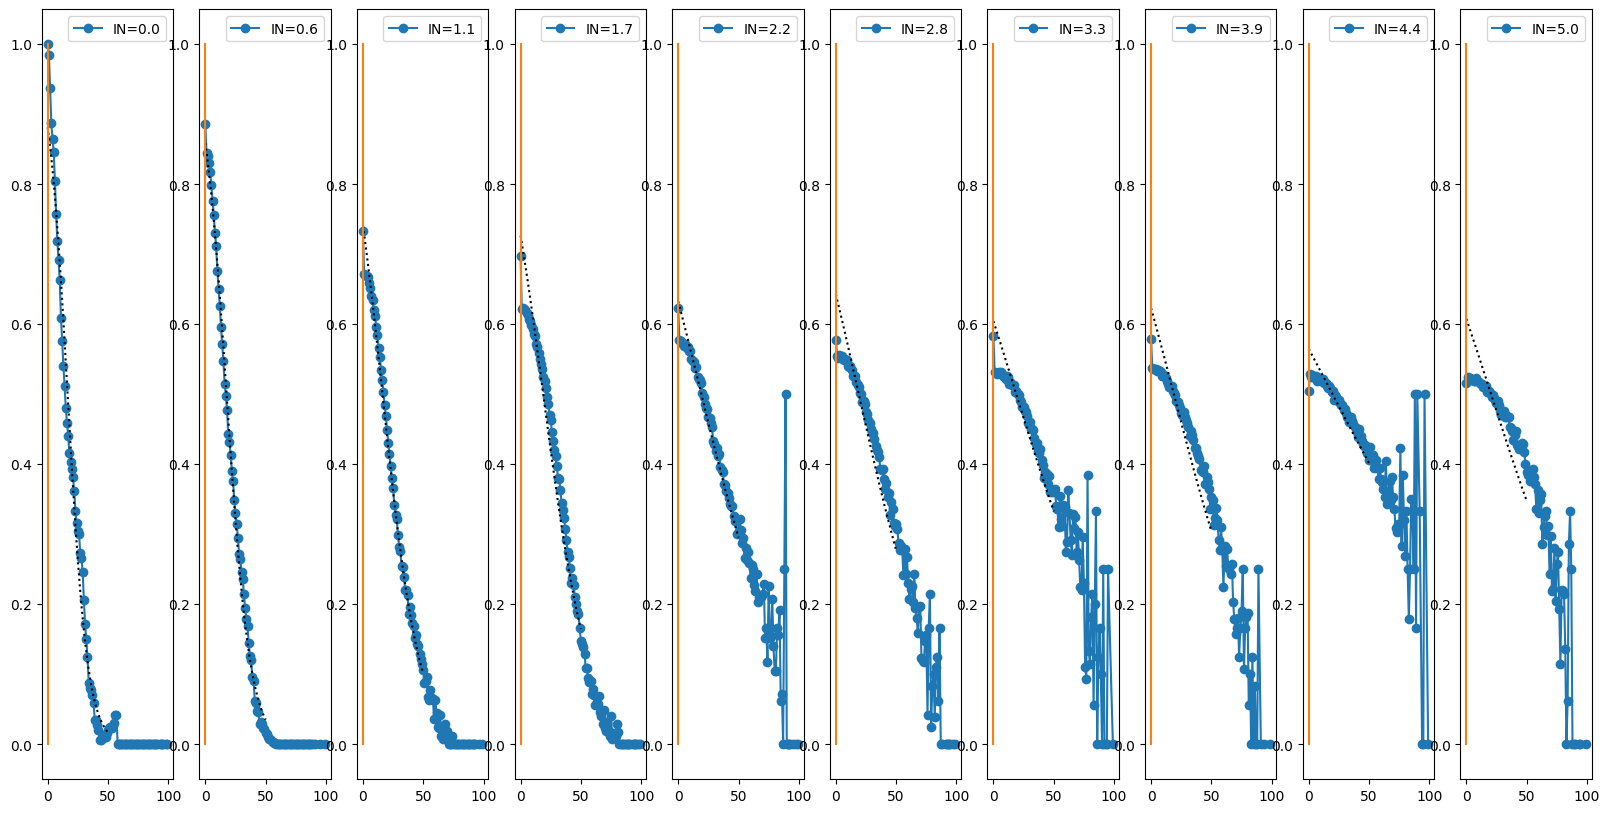

In [344]:
INs = np.linspace(0,5,10)

plt.subplots(figsize=(20,10))

exp = DoublePassExperiment(n_trials = 1000,n_repeated=1000, 
                       trial_type = Int2Trial, 
                       n_features = 6, 
                       external_noise_std = 100)    
    
for index, internal_noise in enumerate(INs):
    
    print('IN: %.1f'%internal_noise)
    # simulate responses
    obs = LinearObserver.with_random_kernel(n_features = exp.n_features,
                                        internal_noise_std = internal_noise, 
                                        criteria = 0)
    responses = obs.respond_to_experiment(exp)
    responses_df = Analyser.to_df(exp, responses)
    
    # group by trial and stim
    df = responses_df.groupby(['trial','stim']).agg({'value':list, 'response':'first'}).reset_index()
    df.value = df.value.apply(lambda x: np.array(x))
    # for each trial, compute trial difference and which stim response
    df = df.groupby(['trial']).agg({'value':lambda x:x.diff().iloc[1], #diff produces 2 lines, the first is nan
                           'response': lambda x: 0 if x.iloc[0] else 1}).reset_index()
    
    from itertools import combinations
    a, b = map(list, zip(*combinations(df.index, 2)))
    comb_df = pd.concat(
        [df.loc[a].add_suffix('_1').reset_index(), df.loc[b].add_suffix('_2').reset_index()], axis=1, 
    ).drop(columns=['index'])

    comb_df['value']=(comb_df.value_1 - comb_df.value_2)
    comb_df['proj_value']= comb_df.value.apply(lambda x: np.abs(x.dot(obs.kernel)))
    comb_df['agree']=(comb_df.response_1==comb_df.response_2).astype(int) 
    comb_df = comb_df.drop(columns=['value_1','value_2','response_1','response_2'])
    
    bins = binned_prob(comb_df,'proj_value',50)
    plt.subplot(1,10,index+1)
    plt.plot(bins.proj_value, bins.agree, 'o-', label='IN=%.1f'%internal_noise)
    
    def func(x, a, b, c):
        return a * np.exp(-b * x) + c

    popt, pcov = curve_fit(sigmoid, bins.proj_value, bins.agree)
    x = np.linspace(0, 50, 50)
    y = sigmoid(x, *popt)
    plt.plot(x,y, 'k:')
    plt.legend()
    plt.plot([0,0],[0,1])


## Simulate with internal noise

Single run

In [ ]:
# single run: 
exp = DoublePassExperiment(n_trials = 1000, n_repeated=200,
          trial_type = Int2Trial, 
          n_features = 5, 
          external_noise_std = 100)
obs = LinearObserver.with_random_kernel(n_features = exp.n_features, 
                            internal_noise_std = 1, 
                            criteria = 0)
responses = obs.respond_to_experiment(exp)
ana = InternalNoiseValue(internal_noise_extractor = DoublePass, model_file='model.csv')
data = ana.analyse(exp, obs, responses)
for name, value in zip(ana.get_metric_names(), data): 
    print("%s: %f"%(name, value))

Simulation

In [ ]:
observer_params = {'kernel':['random'],#[[0,0,0,0,0]]
                   'internal_noise_std':np.arange(0,5.1,0.1), 
                  'criteria':[0]}
experiment_params = {'n_trials':[1000], 
                     'n_repeated':[200],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [1]}
analyser_params = {'internal_noise_extractor':[DoublePass], 
                   'model_file': ['model.csv'], 
                   'rebuild_model': [False]}
                   #'internal_noise_range':[np.arange(0,5.1,0.1)],
                   #'criteria_range':[np.arange(-5,5,0.1)],
                   #'n_runs':[2]}
                  
sim = Sim(DoublePassExperiment, experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params)
sim_df = sim.run_all_single_thread(n_runs=1)



In [ ]:
sns.lineplot(data=sim_df, x='internal_noise_std', y='estimated_internal_noise')
plt.plot([0,5],[0,5],':')

## Experiment with multiprocessing

In [ ]:
observer_params = {'kernel':['random'],#[[0,0,0,0,0]]
                   'internal_noise_std':np.arange(0,5.1,0.1), 
                  'criteria':[0]}
experiment_params = {'n_trials':[1000], 
                     'n_repeated':[200],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [1]}
analyser_params = {'internal_noise_extractor':[DoublePass], 
                   'model_file': ['model.csv'], 
                   'rebuild_model': [False]}
                   #'internal_noise_range':[np.arange(0,5.1,0.1)],
                   #'criteria_range':[np.arange(-5,5,0.1)],
                   #'n_runs':[2]}
                  
sim = Sim(DoublePassExperiment, experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params)

sim.run_all_multi_thread(n_runs=1)


 50%|█████     | 1/2 [00:00<00:00,  1.38it/s]

In [ ]:
model = DoublePass.build_model(internal_noise_range=np.arange(0,5,.1),
                               criteria_range=np.arange(-5,5,.5),
                               n_repeated_trials=1000, n_runs=10)

In [ ]:
model.to_csv('model_large.csv')

## Simulate with kernels

Single run

In [ ]:
# single run: 
exp = SimpleExperiment(n_trials = 100,
          trial_type = Int2Trial, 
          n_features = 5, 
          external_noise_std = 100)
obs = LinearObserver.with_random_kernel(n_features = 5, 
                            internal_noise_std = 1, 
                            criteria = 0)
responses = obs.respond_to_experiment(exp)
ka = KernelDistance(LMMExtractor)
ka.analyse(exp, obs, responses)

In [ ]:
# obs = Obs.with_random_kernel(n_features=5, internal_noise_std=0, criteria=0)

observer_params = {'kernel':['random'],
                   'internal_noise_std':[1], 
                  'criteria':[0]}
experiment_params = {'n_trials':[100],#np.arange(1,1000,100),
                     'trial_type': [Int2Trial],
                     'n_features': np.arange(2,10,1),
                     'external_noise_std': [100]}
analyser_params = {'kernel_extractor':[ClassificationImage], 
                  'distance':['CORR']}


sim = Sim(SimpleExperiment, experiment_params, 
          LinearObserver, observer_params, 
          KernelDistance, analyser_params)
sim_df = sim.run_all(n_runs=10)






In [ ]:
sim_df

In [ ]:
sns.lineplot(data=sim_df, 
             x='n_features',
             y='corr')#, hue='n_features')